<a href="https://colab.research.google.com/github/samuelaojih/Google-Colab/blob/main/Congo_Basin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
### 1. Install Required Libraries
!pip install earthengine-api geemap rasterio

In [3]:
### 2. Import Libraries
import ee
import geemap
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob
import rasterio
from rasterio.merge import merge

In [7]:
# =============================================================================
# GOOGLE EARTH ENGINE INITIALIZATION
# =============================================================================

# Authenticate and initialize Earth Engine
try:
    ee.Authenticate()
    ee.Initialize(project='ee-samuelojihcool') # Added closing quote here
    print("✅ Google Earth Engine initialized successfully!")
except Exception as e:
    print(f"❌ GEE initialization failed: {e}")
    print("Please follow the authentication process above.")

✅ Google Earth Engine initialized successfully!


In [10]:
### 4. Core GEE Logic

# Load the ROI from an asset
roi_ee = ee.FeatureCollection("projects/ee-samuelojihcool/assets/Congo_Basin_Shapefile")

# Load MODIS NDVI dataset (MOD13A2) and filter for NDVI
# Using MODIS/061/MOD13A2 for NDVI data.
# Filtered for a broad date range covering the study period.
modis_ndvi = ee.ImageCollection("MODIS/061/MOD13A2") \
             .select('NDVI') \
             .filterDate('2005-01-01', '2025-05-31')

# Function to scale the NDVI values from 16-bit integer to floating point (0-1)
def scale_ndvi(img):
  # MODIS NDVI values are scaled by 0.0001
  return img.multiply(0.0001).set('system:time_start', img.get('system:time_start'))

# Apply scaling to the NDVI dataset
scaled_ndvi = modis_ndvi.map(scale_ndvi)

# Calculate the mean NDVI for the entire time range
mean_ndvi = scaled_ndvi.mean()

# Visualize the mean NDVI as a layer
mean_ndvi_vis = {
  'min': 0, # Typical min NDVI value for vegetation
  'max': 0.8, # Typical max NDVI value for dense vegetation
  'palette': ['blue', 'red', 'yellow', 'orange', 'green'] # Color ramp from low to high NDVI
}

# Extract NDVI values at the ROI for charting (server-side)
ndvi_time_series_features = scaled_ndvi.map(lambda img: \
  ee.Feature(None, {
    'date': ee.Date(img.get('system:time_start')).format('YYYY-MM-dd'),
    'ndvi': img.reduceRegion(reducer=ee.Reducer.first(), geometry=roi_ee, scale=1000).get('NDVI')
  })
)

# Convert the results to a FeatureCollection (server-side)
ndvi_collection_ee = ee.FeatureCollection(ndvi_time_series_features)
print('NDVI Data Collection (GEE Server Object):', ndvi_collection_ee.limit(5).getInfo())

### 5. Interactive Map Display
# Create and display map
m = geemap.Map()

# Add ROI to the map
m.addLayer(roi_ee, {'color': 'red'}, 'ROI')

# Center the map on the ROI
m.centerObject(roi_ee, 4)

# Add the mean NDVI layer to the map
m.addLayer(mean_ndvi.clip(roi_ee), mean_ndvi_vis, 'Mean NDVI')

# Display the map
m

NDVI Data Collection (GEE Server Object): {'type': 'FeatureCollection', 'columns': {}, 'version': 1762159101658109, 'id': 'MODIS/061/MOD13A2', 'properties': {'system:is_global': 1}, 'features': [{'type': 'Feature', 'geometry': None, 'id': '2005_01_01', 'properties': {'date': '2005-01-01', 'ndvi': 0.5453}}, {'type': 'Feature', 'geometry': None, 'id': '2005_01_17', 'properties': {'date': '2005-01-17', 'ndvi': 0.3647}}, {'type': 'Feature', 'geometry': None, 'id': '2005_02_02', 'properties': {'date': '2005-02-02', 'ndvi': 0.33330000000000004}}, {'type': 'Feature', 'geometry': None, 'id': '2005_02_18', 'properties': {'date': '2005-02-18', 'ndvi': 0.7425}}, {'type': 'Feature', 'geometry': None, 'id': '2005_03_06', 'properties': {'date': '2005-03-06', 'ndvi': 0.5058}}]}


Map(center=[-2.5123409128532685, 22.897031608250234], controls=(WidgetControl(options=['position', 'transparen…

In [11]:
### 6. Download shapefile
# Define the output path for the shp.
output_path = "shapefile"
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Export the ROI as a shapefile
geemap.ee_export_vector(
    ee_object=roi_ee,
    filename=os.path.join(output_path, "congo_basin_roi.shp"),
    verbose=True
)

Generating URL ...
Please wait ...
Data downloaded to /content/shapefile/congo_basin_roi.shp


In [12]:
### 7. Export to Google Drive
# Export the mean NDVI image to Google Drive
task = ee.batch.Export.image.toDrive(
    image=mean_ndvi.clip(roi_ee),
    description='Mean_NDVI_Congo_Basin',
    folder='GEE_Exports',
    fileNamePrefix='mean_ndvi_congo_basin',
    region=roi_ee.geometry(),
    scale=1000, # MODIS resolution is 250m, 1000m is a reasonable export scale
    crs='EPSG:4326', # Standard geographic CRS
    maxPixels=1e13
)
task.start()

print("Export task for Mean NDVI initiated to Google Drive. Check your GEE Tasks tab.")

Export task for Mean NDVI initiated to Google Drive. Check your GEE Tasks tab.


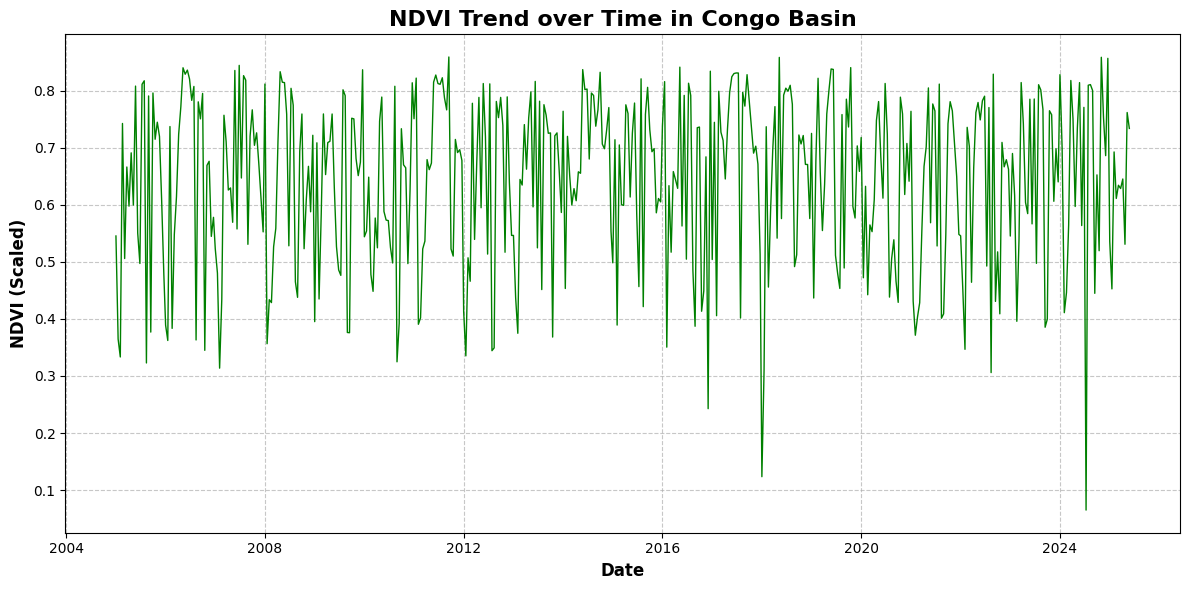

In [13]:
### 8. Create Matplotlib Charts
# Get the client-side data for charting
ndvi_data_client = ndvi_collection_ee.getInfo()['features']

# Convert to Pandas DataFrame
df = pd.DataFrame([f['properties'] for f in ndvi_data_client])

# Convert 'date' column to datetime and 'ndvi' to numeric
df['date'] = pd.to_datetime(df['date'])
df['ndvi'] = pd.to_numeric(df['ndvi'])

# Sort by date
df = df.sort_values(by='date')

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['ndvi'], color='green', linewidth=1)
plt.title('NDVI Trend over Time in Congo Basin', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('NDVI (Scaled)', fontsize=12, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [14]:
### 9. Export CSV to Local Folder
def export_time_series_dataframe(collection, bands, region, scale, reducer, folder, name):
    reducers = {'mean': ee.Reducer.mean(), 'sum': ee.Reducer.sum(), 'min': ee.Reducer.min(), \
                'max': ee.Reducer.max(), 'median': ee.Reducer.median(), 'first': ee.Reducer.first()}
    ee_reducer = reducers.get(reducer)
    if ee_reducer is None:
        raise ValueError(f'Unsupported reducer: {reducer}')

    def extract_properties(img):
        stats = img.reduceRegion(reducer=ee_reducer, geometry=region, scale=scale, maxPixels=1e13)
        stats = stats.set('date', img.date().format('YYYY-MM-dd'))
        return ee.Feature(None, stats)

    features = collection.select(bands).map(extract_properties)
    feature_list = features.getInfo()['features']
    dataframe = pd.DataFrame([f['properties'] for f in feature_list])

    if not dataframe.empty:
        dataframe['date'] = pd.to_datetime(dataframe['date'])
        # Ensure the folder exists
        os.makedirs(folder, exist_ok=True)
        csv_path = os.path.join(folder, name)
        dataframe.to_csv(csv_path, index=False)
        print(f'Time series CSV saved to: {csv_path}')
    else:
        print("No data to export.")
    return dataframe

# Define parameters for export
csv_folder = 'csv_exports'
csv_name = 'ndvi_time_series_congo_basin.csv'

# Export the time series data to CSV
ndvi_df = export_time_series_dataframe(
    collection=scaled_ndvi,
    bands=['NDVI'],
    region=roi_ee,
    scale=1000,
    reducer='first',
    folder=csv_folder,
    name=csv_name
)

if ndvi_df is not None and not ndvi_df.empty:
    print("First 5 rows of the exported DataFrame:")
    print(ndvi_df.head())

Time series CSV saved to: csv_exports/ndvi_time_series_congo_basin.csv
First 5 rows of the exported DataFrame:
     NDVI       date
0  0.5453 2005-01-01
1  0.3647 2005-01-17
2  0.3333 2005-02-02
3  0.7425 2005-02-18
4  0.5058 2005-03-06


In [18]:
### 10. Downloading Image in Tiles
# Extract the bounding box of the ROI as a polygon.
roi_boundary = roi_ee.geometry().bounds() # Assuming roi_ee is the FeatureCollection

# Create a fishnet grid. Adjust rows/cols based on ROI size and desired tile resolution.
# For a larger area or higher resolution, increase rows and cols.
mesh = geemap.fishnet(roi_boundary, rows=3, cols=3, delta=0)

# Create a new map to visualize the tiles
m2 = geemap.Map()
m2.addLayer(roi_ee, {'color': 'red'}, 'ROI')
m2.addLayer(mean_ndvi.clip(roi_ee), mean_ndvi_vis, 'Mean NDVI')

# Add the grid to the map to visualize the tiles.
vis_params_grid = {'color': 'yellow', 'fillColor': '00000000'}
m2.addLayer(mesh.style(**vis_params_grid), {}, "Mesh Grid")
m2.centerObject(roi_ee, 4)
m2

# Define the output path for the tiles.
output_path = "downloads"
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Define the image to download (mean_ndvi clipped to ROI)
image_to_download = mean_ndvi.clip(roi_ee)

# Download the image by tiles using the mesh grid.
# CRS and scale should be chosen appropriately for the analysis.
geemap.download_ee_image_tiles(
    image=image_to_download,
    features=mesh,
    out_dir=output_path,
    prefix="Image_",
    crs="EPSG:4326", # Example CRS, should be adjusted for MODIS data
    scale=1000 # Example scale, should be adjusted for MODIS data
)

  0%|          |0/4 tiles [00:00<?]

  0%|          |0/4 tiles [00:00<?]

  0%|          |0/4 tiles [00:00<?]

  0%|          |0/4 tiles [00:00<?]

  0%|          |0/4 tiles [00:00<?]

  0%|          |0/4 tiles [00:00<?]

Downloaded 6 tiles in 188.68413591384888 seconds.


In [17]:
!pip install geedim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 2.6 MB/s eta 0:00:00


In [19]:
### 11. Merging Downloaded Tiles
# Find all downloaded tile .tif files in the output path.
tile_files = glob.glob(os.path.join(output_path, '*.tif'))

# Open each tile as a rasterio dataset.
src_files_to_mosaic = [rasterio.open(fp) for fp in tile_files]

if src_files_to_mosaic:
    # Merge the tiles and get the output transform.
    mosaic, out_trans = merge(src_files_to_mosaic)

    # Prepare metadata for the output merged raster.
    out_meta = src_files_to_mosaic[0].meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        "crs": src_files_to_mosaic[0].crs # Copy CRS from source
    })

    # Define the path for the final merged raster file.
    merged_tif_path = os.path.join(output_path, "final_merged_image.tif")

    # Write the merged mosaic to disk.
    with rasterio.open(merged_tif_path, "w", **out_meta) as dest:
        dest.write(mosaic)

    print(f"Mosaic created and saved to: {merged_tif_path}")

    # Close all source files
    for src in src_files_to_mosaic:
        src.close()
else:
    print("No tile files found to merge.")

Mosaic created and saved to: downloads/final_merged_image.tif


In [20]:
### 12. Additional Colab-specific utilities
# List all files in current directory structure
print("Current directory structure:")
!find . -type f -name "*.shp" -o -name "*.csv" -o -name "*.tif" | head -20

# Create a zip file of all outputs for download
!zip -r gee_analysis_outputs.zip shapefile/ csv_exports/ downloads/ 2>/dev/null || true

print("\nIf you want to download the outputs, use Colab's file browser or run:")
print("from google.colab import files")
print("files.download('gee_analysis_outputs.zip')")

Current directory structure:
./shapefile/congo_basin_roi.shp
./downloads/Image_3.tif
./downloads/Image_5.tif
./downloads/Image_4.tif
./downloads/final_merged_image.tif
./downloads/Image_2.tif
./downloads/Image_1.tif
./downloads/Image_6.tif
./csv_exports/ndvi_time_series_congo_basin.csv
./sample_data/mnist_test.csv
./sample_data/mnist_train_small.csv
./sample_data/california_housing_train.csv
./sample_data/california_housing_test.csv
  adding: shapefile/ (stored 0%)
  adding: shapefile/congo_basin_roi.shx (deflated 45%)
  adding: shapefile/congo_basin_roi.cpg (stored 0%)
  adding: shapefile/congo_basin_roi.prj (deflated 39%)
  adding: shapefile/congo_basin_roi.fix (deflated 60%)
  adding: shapefile/congo_basin_roi.shp (deflated 13%)
  adding: shapefile/congo_basin_roi.dbf (deflated 50%)
  adding: csv_exports/ (stored 0%)
  adding: csv_exports/ndvi_time_series_congo_basin.csv (deflated 74%)
  adding: downloads/ (stored 0%)
  adding: downloads/Image_3.tif (deflated 0%)
  adding: downloads

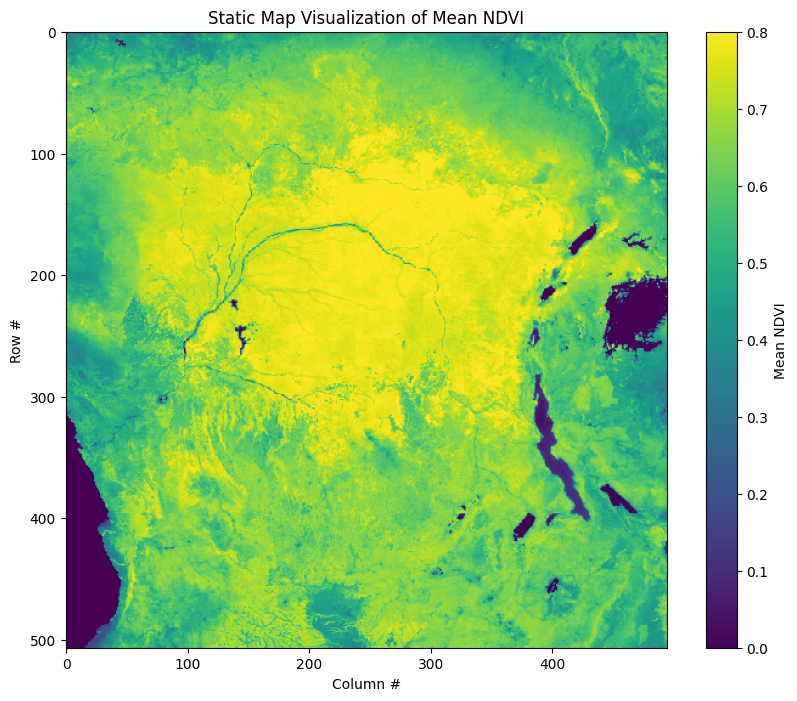

In [22]:
# Convert the mean NDVI Earth Engine image to a NumPy array for Matplotlib
# You might need to adjust the region and scale based on your requirements
# Increased scale to reduce request size. If error persists, consider using geemap.ee_to_numpy_tiles.
mean_ndvi_np = geemap.ee_to_numpy(mean_ndvi.clip(roi_ee), region=roi_ee.geometry(), scale=5000)

# Plot the NumPy array using Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(mean_ndvi_np, cmap='viridis', vmin=0, vmax=0.8) # Adjust cmap, vmin, vmax based on your data
plt.colorbar(label='Mean NDVI')
plt.title('Static Map Visualization of Mean NDVI')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

📊 Creating static visualization of downloads/final_merged_image.tif...
✅ Static plot saved:
Output/mean_ndvi_static_plot.jpg


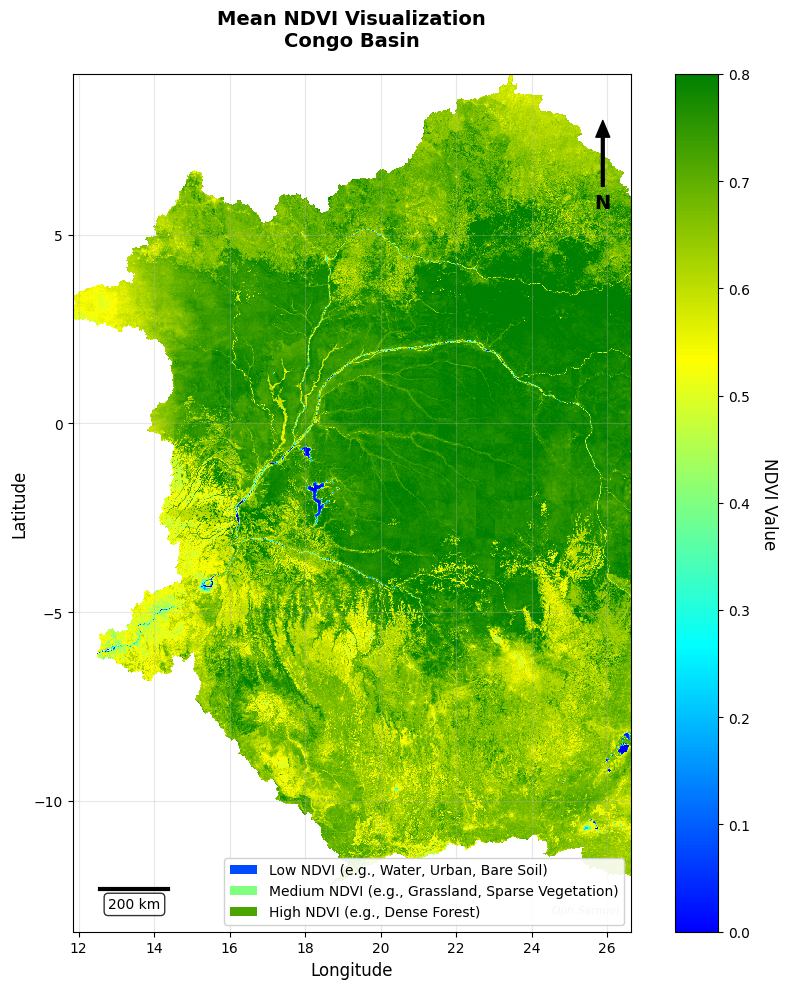

In [25]:
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import numpy as np # Import numpy for scale bar calculation
from matplotlib.patches import Patch # Import Patch for custom legend

# Define the path to the merged GeoTIFF file
merged_tif_path = os.path.join("downloads", "final_merged_image.tif")
output_dir = "Output" # Define output directory for saving the plot

print(f"📊 Creating static visualization of {merged_tif_path}...")

try:
    # Read the mosaicked raster
    with rasterio.open(merged_tif_path) as src:
        # Read the first band (NDVI)
        ndvi_data = src.read(1)
        transform = src.transform
        crs = src.crs

        # Get bounds
        left, bottom, right, top = src.bounds

    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))

    # Create custom colormap for NDVI (adjust colors and range as needed)
    # Example colormap from blue (low NDVI) to green (high NDVI)
    colors = ['blue', 'cyan', 'yellow', 'green']
    cmap = mcolors.LinearSegmentedColormap.from_list('ndvi_cmap', colors, N=256)

    # Plot NDVI
    # Set vmin and vmax based on typical NDVI range (0 to 1)
    im = ax.imshow(ndvi_data,
                   extent=[left, right, bottom, top],
                   cmap=cmap,
                   vmin=0,
                   vmax=0.8, # Adjust max based on your data's actual range
                   interpolation='nearest')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('NDVI Value', rotation=270, labelpad=20, fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    # Set title and labels
    ax.set_title('Mean NDVI Visualization\nCongo Basin',
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)

    # Add grid
    ax.grid(True, alpha=0.3)

    # -------------------------------------------------------------------------
    # Dynamic scale bar
    # -------------------------------------------------------------------------
    def add_scalebar(ax, length_km=None, location=(0.05, 0.05), linewidth=3):
        # Approximate conversion factor for degrees to meters at the center latitude
        lat_center = (top + bottom) / 2
        # 1 degree of longitude is about 111320 meters at the equator
        # and varies with cosine of latitude.
        # 1 degree of latitude is about 110574 meters (fairly constant)
        # Since we are using degrees for extent, we need to convert map units to meters
        # using the bounds and the approximate degree to meter conversion at the center latitude.

        # Calculate the width of the map in meters
        map_width_degrees = right - left
        # Simple approximation: assume 1 degree is roughly 111 km or 111000 meters
        # This is a rough estimate and might not be accurate for large areas or high precision
        # A more accurate method would involve projecting the data or using a more sophisticated library

        # Let's use a simplified approach based on the extent
        # The scale bar length in data units (degrees) will be proportional to the desired length in km

        if length_km is None:
            # Estimate a reasonable scale bar length
            # Target length is roughly 1/10th of the map width
            target_length_degrees = (right - left) / 10
            # Convert target length in degrees to km using a rough estimate
            target_length_km = target_length_degrees * 111 # Rough estimate: 1 degree ~ 111 km

            # Choose a nice rounded value for the scale bar length in km
            possible_lengths = np.array([10, 20, 50, 100, 200, 500, 1000]) # Common scale bar lengths
            length_km = possible_lengths[np.argmin(abs(possible_lengths - target_length_km))]

        length_degrees = length_km / 111. # Convert length back to degrees using rough estimate

        # Calculate start and end points for the scale bar in data coordinates (degrees)
        x_start = left + (right - left) * location[0]
        y_start = bottom + (top - bottom) * location[1]
        x_end = x_start + length_degrees

        ax.plot([x_start, x_end], [y_start, y_start], color='black', linewidth=linewidth)
        # Add text label below the scale bar
        ax.text((x_start + x_end)/2, y_start - (top - bottom)*0.01, f'{int(length_km)} km', # Adjust text position
                ha='center', va='top', fontsize=10, color='black',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    # Add the scale bar to the map
    add_scalebar(ax)


    # -------------------------------------------------------------------------
    # Add north arrow (Top right)
    # -------------------------------------------------------------------------
    ax.annotate('N',
                xy=(0.95, 0.95), xytext=(0.95, 0.85), # Adjusted positions for better placement
                arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=10),
                ha='center', va='center',
                fontsize=14, fontweight='bold',
                xycoords='axes fraction', textcoords='axes fraction') # Use 'axes fraction' for relative positioning


    # -------------------------------------------------------------------------
    # Legend (bottom right)
    # -------------------------------------------------------------------------
    # Create legend elements based on the NDVI color ramp
    # This is a simplified legend. For a more detailed one, you might need to define ranges.
    legend_elements = [
        Patch(facecolor=cmap(0.1), label='Low NDVI (e.g., Water, Urban, Bare Soil)'), # Example: Corresponds to blue/cyan
        Patch(facecolor=cmap(0.5), label='Medium NDVI (e.g., Grassland, Sparse Vegetation)'), # Example: Corresponds to yellow/orange
        Patch(facecolor=cmap(0.9), label='High NDVI (e.g., Dense Forest)') # Example: Corresponds to green
    ]

    legend = ax.legend(handles=legend_elements, loc='lower right',
                       bbox_to_anchor=(1, 0), framealpha=0.9)

    # -------------------------------------------------------------------------
    # Signature
    # -------------------------------------------------------------------------
    ax.text(0.98, 0.02, 'Ojih Samuel', transform=ax.transAxes,
            fontsize=8, color='gray', alpha=0.7,
            ha='right', va='bottom', style='italic')

    plt.tight_layout()

    # Save plot
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, 'mean_ndvi_static_plot.jpg'), dpi=300, bbox_inches='tight', facecolor='white')
    print("✅ Static plot saved:")
    print(os.path.join(output_dir, 'mean_ndvi_static_plot.jpg'))


    # Display plot
    plt.show()

except FileNotFoundError:
    print(f"❌ Error: {merged_tif_path} not found. Make sure the tile merging step was successful.")
except Exception as e:
    print(f"❌ An error occurred during visualization: {e}")

In [28]:
# =============================================================================
# DATA EXPORT - NDVI TILES
# =============================================================================

import os
import geemap # Ensure geemap is imported if not already in this scope

# Define the output path for the tiles.
# You can change 'ndvi_tiles_export' to a different folder name if desired.
output_path_tiles = "ndvi_tiles_export"
if not os.path.exists(output_path_tiles):
    os.makedirs(output_path_tiles)
    print(f"📁 Created directory: {output_path_tiles}")
else:
    print(f"📁 Output directory already exists: {output_path_tiles}")


print(f"\n⬇️ Exporting Mean NDVI tiles to {output_path_tiles}...")

# Define the image to download (mean_ndvi clipped to ROI)
image_to_download_tiles = mean_ndvi.clip(roi_ee)

# You can reuse the mesh from cell LeTrhy_T8qfe if it's still in memory and appropriate,
# or create a new one with desired rows/cols.
# For demonstration, let's use the ROI bounds to create a simple mesh if 'mesh' is not defined
try:
    mesh
except NameError:
    print("Creating a new mesh for tiling...")
    roi_boundary_tiles = roi_ee.geometry().bounds()
    # Adjust rows/cols based on ROI size and desired tile resolution.
    # For a larger area or higher resolution, increase rows and cols.
    mesh = geemap.fishnet(roi_boundary_tiles, rows=3, cols=3, delta=0)


# Download the image by tiles using the mesh grid.
# CRS and scale should be chosen appropriately for the analysis.
# Using a scale of 1000m which was used in earlier successful steps.
geemap.download_ee_image_tiles(
    image=image_to_download_tiles,
    features=mesh, # Use the defined mesh
    out_dir=output_path_tiles,
    prefix="mean_ndvi_tile_",
    crs="EPSG:4326", # Example CRS, should be adjusted for MODIS data
    scale=1000 # Example scale, adjusted based on MODIS data and previous success
)

print("✅ Export of Mean NDVI tiles initiated.")

📁 Created directory: ndvi_tiles_export

⬇️ Exporting Mean NDVI tiles to ndvi_tiles_export...


  0%|          |0/4 tiles [00:00<?]

  0%|          |0/4 tiles [00:00<?]

  0%|          |0/4 tiles [00:00<?]

  0%|          |0/4 tiles [00:00<?]

  0%|          |0/4 tiles [00:00<?]

  0%|          |0/4 tiles [00:00<?]

Downloaded 6 tiles in 166.43673515319824 seconds.
✅ Export of Mean NDVI tiles initiated.


### Export ROI as Shapefile

You already have code in cell `l4x0KYyT6O1n` that exports the `roi_ee` FeatureCollection as a shapefile to the `shapefile` folder.

In [31]:
### Export Full Mean NDVI Image to Local File

import os
import geemap

# Define the output path for the full image.
output_path_full_image = "downloads/mean_ndvi_full_image.tif" # Save in the downloads folder

print(f"⬇️ Exporting full Mean NDVI image to {output_path_full_image}...")

# Define the image to export (mean_ndvi clipped to ROI)
# Get the bounding box of the ROI FeatureCollection
roi_bounds_geometry = roi_ee.geometry().bounds()

# Clip the image to the bounding box
image_to_export_full = mean_ndvi.clip(roi_bounds_geometry)

# Export the image to a local file
# Using the same scale as the static visualization (5000m) for a manageable size
# If you need higher resolution, you might need to export as tiles (cell 0e39ca8d)
geemap.ee_export_image(
    ee_object=image_to_export_full,
    filename=output_path_full_image,
    scale=5000, # Use a coarser scale to avoid memory issues for a full image export
    crs="EPSG:4326",
    file_per_band=False # Export as a single file if multiple bands
)

print("✅ Export of full Mean NDVI image initiated.")

⬇️ Exporting full Mean NDVI image to downloads/mean_ndvi_full_image.tif...
Generating URL ...
Please wait ...
Data downloaded to /content/downloads/mean_ndvi_full_image.tif
✅ Export of full Mean NDVI image initiated.


In [29]:
# =============================================================================
# DATA ANALYSIS AND SUMMARY - NDVI
# =============================================================================

import rasterio
import numpy as np
import os

# Define the path to the merged GeoTIFF file
merged_tif_path = os.path.join("downloads", "final_merged_image.tif")

print("\n" + "="*60)
print("📈 DATA ANALYSIS SUMMARY - NDVI")
print("="*60)

try:
    # Basic statistics
    with rasterio.open(merged_tif_path) as src:
        ndvi_data = src.read(1)
        # Rasterio reads nodata as nan by default for float types, good for nan-aware numpy functions
        ndvi_clean = ndvi_data[~np.isnan(ndvi_data)]  # Remove NaN values for certain calculations if needed, but np.nan* functions handle them

    print(f"📊 NDVI Statistics:")
    # Use np.nan* functions to handle potential NaN values gracefully
    print(f"   Minimum: {np.nanmin(ndvi_data):.3f}")
    print(f"   Maximum: {np.nanmax(ndvi_data):.3f}")
    print(f"   Mean:    {np.nanmean(ndvi_data):.3f}")
    print(f"   Median:  {np.nanmedian(ndvi_data):.3f}")
    print(f"   Std Dev: {np.nanstd(ndvi_data):.3f}")

    # Basic land cover analysis based on NDVI ranges
    # Define NDVI ranges for different land cover types (these are examples and may need adjustment)
    low_vegetation_threshold = 0.2
    medium_vegetation_threshold = 0.5

    low_vegetation_pixels = np.sum(ndvi_data < low_vegetation_threshold)
    medium_vegetation_pixels = np.sum((ndvi_data >= low_vegetation_threshold) & (ndvi_data < medium_vegetation_threshold))
    high_vegetation_pixels = np.sum(ndvi_data >= medium_vegetation_threshold)
    total_valid_pixels = np.sum(~np.isnan(ndvi_data))


    print(f"\n🌱 NDVI-based Land Cover Analysis (Example Ranges):")
    print(f"   Low Vegetation (< {low_vegetation_threshold:.2f}): {low_vegetation_pixels:,} pixels ({ (low_vegetation_pixels / total_valid_pixels * 100 if total_valid_pixels > 0 else 0):.2f}%)")
    print(f"   Medium Vegetation ({low_vegetation_threshold:.2f} to < {medium_vegetation_threshold:.2f}): {medium_vegetation_pixels:,} pixels ({ (medium_vegetation_pixels / total_valid_pixels * 100 if total_valid_pixels > 0 else 0):.2f}%)")
    print(f"   High Vegetation (>= {medium_vegetation_threshold:.2f}): {high_vegetation_pixels:,} pixels ({ (high_vegetation_pixels / total_valid_pixels * 100 if total_valid_pixels > 0 else 0):.2f}%)")
    print(f"   Total valid pixels: {total_valid_pixels:,}")

    # -------------------------------------------------------------------------
    # Area calculation (approximate)
    # Using the scale of the downloaded image (1000m)
    pixel_resolution_meters = 1000
    pixel_area_sqkm = (pixel_resolution_meters * pixel_resolution_meters) / 1e6  # Pixel area in sq km

    total_area_sqkm = total_valid_pixels * pixel_area_sqkm
    low_veg_area_sqkm = low_vegetation_pixels * pixel_area_sqkm
    medium_veg_area_sqkm = medium_vegetation_pixels * pixel_area_sqkm
    high_veg_area_sqkm = high_vegetation_pixels * pixel_area_sqkm


    print(f"\n📏 Estimated Area Analysis:")
    print(f"   Total study area: {total_area_sqkm:,.2f} sq km")
    print(f"   Estimated Low Vegetation area: {low_veg_area_sqkm:,.2f} sq km")
    print(f"   Estimated Medium Vegetation area: {medium_veg_area_sqkm:,.2f} sq km")
    print(f"   Estimated High Vegetation area: {high_veg_area_sqkm:,.2f} sq km")


except FileNotFoundError:
    print(f"❌ Error: {merged_tif_path} not found. Make sure the tile merging step was successful.")
except Exception as e:
    print(f"❌ An error occurred during data analysis: {e}")


📈 DATA ANALYSIS SUMMARY - NDVI
📊 NDVI Statistics:
   Minimum: -inf
   Maximum: 0.845
   Mean:    -inf
   Median:  0.644
   Std Dev: nan

🌱 NDVI-based Land Cover Analysis (Example Ranges):
   Low Vegetation (< 0.20): 1,417,876 pixels (34.05%)
   Medium Vegetation (0.20 to < 0.50): 40,297 pixels (0.97%)
   High Vegetation (>= 0.50): 2,706,207 pixels (64.98%)
   Total valid pixels: 4,164,380

📏 Estimated Area Analysis:
   Total study area: 4,164,380.00 sq km
   Estimated Low Vegetation area: 1,417,876.00 sq km
   Estimated Medium Vegetation area: 40,297.00 sq km
   Estimated High Vegetation area: 2,706,207.00 sq km
